In [7]:
import cv2
import os
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

In [2]:
# Base directory
BASE_DIR = '/kaggle/input/pc3-data/PC3_data_split'

# Use the 'test' set for evaluation
TEST_IMG_DIR = os.path.join(BASE_DIR, 'test', 'images')
TEST_MASK_DIR = os.path.join(BASE_DIR, 'test', 'masks')


In [3]:
NUM_SAMPLES_TO_SAVE = 2  # comparison images to save
OUTPUT_DIR = '/kaggle/working/segmentation_results' # Folder to save them

In [4]:
def dice_coefficient(gt_mask, pred_mask):
    # Calculates the Dice coefficient (F1 score)
    # Ensure masks are boolean (0 or 1)
    gt_mask = gt_mask.astype(bool)
    pred_mask = pred_mask.astype(bool)
    
    intersection = np.sum(gt_mask & pred_mask)
    total = np.sum(gt_mask) + np.sum(pred_mask)
    
    # Add a small epsilon to avoid division by zero
    dice = (2. * intersection + 1e-6) / (total + 1e-6)
    return dice

In [5]:
def iou_score(gt_mask, pred_mask):
    # Calculates the Intersection over Union (Jaccard index)
    # Ensure masks are boolean (0 or 1)
    gt_mask = gt_mask.astype(bool)
    pred_mask = pred_mask.astype(bool)
    
    intersection = np.sum(gt_mask & pred_mask)
    union = np.sum(gt_mask | pred_mask)
    
    # Add a small epsilon to avoid division by zero
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou

In [2]:
def precision_score(gt_mask, pred_mask):
    tp = np.logical_and(pred_mask == 1, gt_mask == 1).sum()
    fp = np.logical_and(pred_mask == 1, gt_mask == 0).sum()
    return tp / (tp + fp + 1e-8)



In [3]:
def recall_score(gt_mask, pred_mask):
    tp = np.logical_and(pred_mask == 1, gt_mask == 1).sum()
    fn = np.logical_and(pred_mask == 0, gt_mask == 1).sum()
    return tp / (tp + fn + 1e-8)

In [1]:
def evaluate_methods(image_dir, mask_dir):
    image_paths = glob.glob(os.path.join(image_dir, '*.png'))
    
    if not image_paths:
        print(f"Error: No images found in {image_dir}")
        return

    # Store all metrics for each method
    scores_simple = {'dice': [], 'iou': [], 'precision': [], 'recall': []}
    scores_otsu = {'dice': [], 'iou': [], 'precision': [], 'recall': []}
    scores_adaptive = {'dice': [], 'iou': [], 'precision': [], 'recall': []}
    
    valid_images_found = 0

    print(f"Processing {len(image_paths)} images from {image_dir}...\n")

    for img_path in image_paths:
        img_name = os.path.basename(img_path)
        mask_name = img_name.replace(".png", "_mask.png")
        mask_path = os.path.join(mask_dir, mask_name)
        
        if not os.path.exists(mask_path):
            print(f"Skipping {img_name} — matching mask not found at {mask_path}")
            continue
        
        valid_images_found += 1

        # --- Load image and ground truth ---
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        gt_mask_display = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        gt_mask = (gt_mask_display > 128).astype(np.uint8)

        # Normalize to 8-bit
        if image.dtype != np.uint8:
            image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # --- (1) Simple Threshold ---
        _, simple_thresh_img = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

        # --- (2) Otsu’s Threshold ---
        _, otsu_thresh_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # --- (3) Adaptive Gaussian Threshold (Fixed grey issue) ---
        adaptive_thresh_img = cv2.adaptiveThreshold(
            image, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            blockSize=21, C=2
        )

        # Invert all thresholded outputs (not the input image)
        simple_thresh_img = cv2.bitwise_not(simple_thresh_img)
        otsu_thresh_img = cv2.bitwise_not(otsu_thresh_img)
        adaptive_thresh_img = cv2.bitwise_not(adaptive_thresh_img)

        # Clean binary conversion
        simple_thresh_img = np.where(simple_thresh_img > 128, 255, 0).astype(np.uint8)
        otsu_thresh_img = np.where(otsu_thresh_img > 128, 255, 0).astype(np.uint8)
        adaptive_thresh_img = np.where(adaptive_thresh_img > 128, 255, 0).astype(np.uint8)

        # Convert to binary masks
        pred_mask_simple = (simple_thresh_img > 128).astype(np.uint8)
        pred_mask_otsu = (otsu_thresh_img > 128).astype(np.uint8)
        pred_mask_adaptive = (adaptive_thresh_img > 128).astype(np.uint8)

        # --- Metrics for each method ---
        for scores, pred in [
            (scores_simple, pred_mask_simple),
            (scores_otsu, pred_mask_otsu),
            (scores_adaptive, pred_mask_adaptive)
        ]:
            scores['dice'].append(dice_coefficient(gt_mask, pred))
            scores['iou'].append(iou_score(gt_mask, pred))
            scores['precision'].append(precision_score(gt_mask, pred))
            scores['recall'].append(recall_score(gt_mask, pred))

        # --- Show a few samples ---
        if valid_images_found <= NUM_SAMPLES_TO_SAVE:
            fig, axes = plt.subplots(1, 5, figsize=(18, 5))
            fig.suptitle(f"Comparison for {img_name}", fontsize=14)
            
            images = [
                (image, "Original"),
                (gt_mask_display, "Ground Truth"),
                (simple_thresh_img, "Simple (127)"),
                (otsu_thresh_img, "Otsu’s"),
                (adaptive_thresh_img, "Adaptive (Gaussian)")
            ]
            
            for ax, (img, title) in zip(axes, images):
                ax.imshow(img, cmap='binary', vmin=0, vmax=255)
                ax.set_title(title)
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()

    # --- Summary ---
    if valid_images_found == 0:
        print("\nError: No valid image-mask pairs were found.")
        return

    def print_avg_metrics(name, scores):
        print(f"\nResults for {name}:")
        print(f"  Avg Dice:      {np.mean(scores['dice']):.4f}")
        print(f"  Avg IoU:       {np.mean(scores['iou']):.4f}")
        print(f"  Avg Precision: {np.mean(scores['precision']):.4f}")
        print(f"  Avg Recall:    {np.mean(scores['recall']):.4f}")

    print(f"\n--- Evaluation Complete ---")
    print(f"Processed {valid_images_found} valid image-mask pairs.")

    print_avg_metrics("Simple Threshold (127)", scores_simple)
    print_avg_metrics("Otsu’s Threshold", scores_otsu)
    print_avg_metrics("Adaptive Threshold (Gaussian)", scores_adaptive)

Processing 114 images from /kaggle/input/pc3-data/PC3_data_split/test/images...



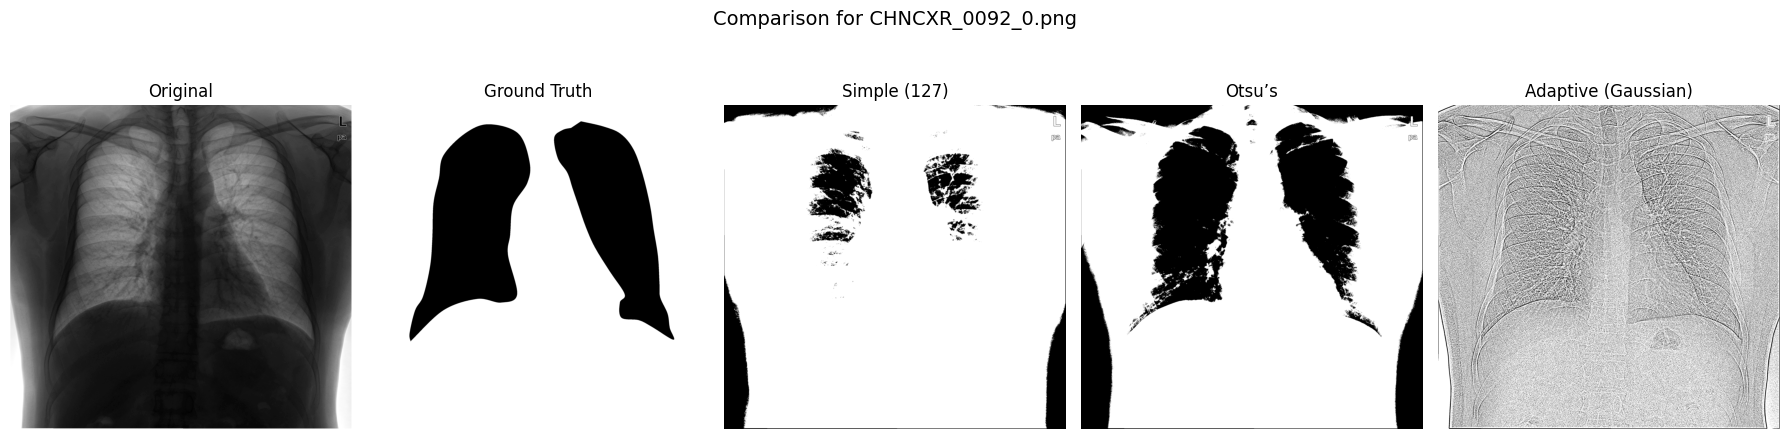

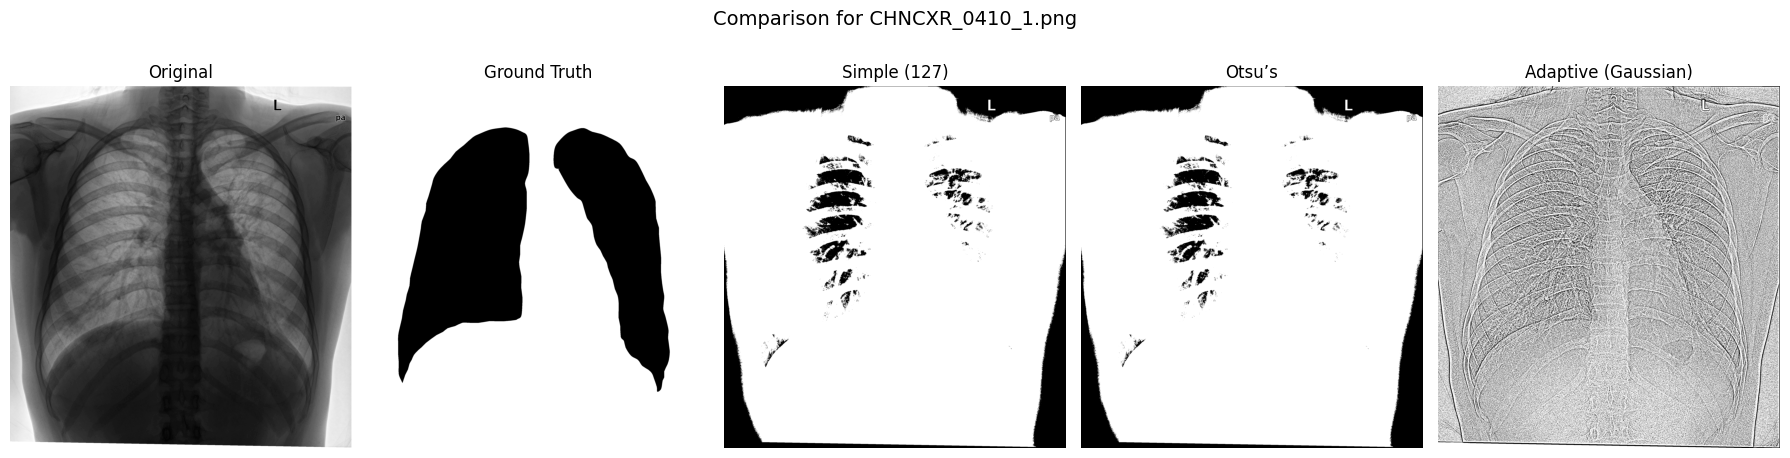


--- Evaluation Complete ---
Processed 114 valid image-mask pairs.

Results for Simple Threshold (127):
  Avg Dice:      0.2518
  Avg IoU:       0.1585
  Avg Precision: 0.2475
  Avg Recall:    0.2824

Results for Otsu’s Threshold:
  Avg Dice:      0.2930
  Avg IoU:       0.1972
  Avg Precision: 0.2655
  Avg Recall:    0.3398

Results for Adaptive Threshold (Gaussian):
  Avg Dice:      0.3254
  Avg IoU:       0.1952
  Avg Precision: 0.3007
  Avg Recall:    0.3656


In [4]:
if __name__ == "__main__":
    evaluate_methods(TEST_IMG_DIR, TEST_MASK_DIR)

In [8]:


def show_histogram_sample(image_dir):
    """
    Displays the histogram and Otsu's threshold for one sample image
    from the given directory.
    """
    # --- Get one image ---
    image_paths = glob.glob(os.path.join(image_dir, '*.png'))
    if not image_paths:
        print(f"No images found in {image_dir}")
        return

    sample_path = image_paths[0]  # pick the first image
    img_name = os.path.basename(sample_path)
    
    # --- Load image in grayscale ---
    image = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Failed to load image: {sample_path}")
        return

    # --- Compute Otsu's threshold ---
    otsu_thresh_val, otsu_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # --- Compute histogram ---
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    # --- Plot histogram and threshold line ---
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(hist, color='gray')
    plt.axvline(x=otsu_thresh_val, color='r', linestyle='--', label=f"Otsu Threshold = {otsu_thresh_val:.0f}")
    plt.title(f"Histogram of '{img_name}'")
    plt.xlabel("Pixel Intensity (0-255)")
    plt.ylabel("Pixel Count")
    plt.legend()

    # --- Show thresholded image next to it ---
    plt.subplot(1, 2, 2)
    plt.imshow(otsu_img, cmap='gray')
    plt.title("Otsu's Threshold Result")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

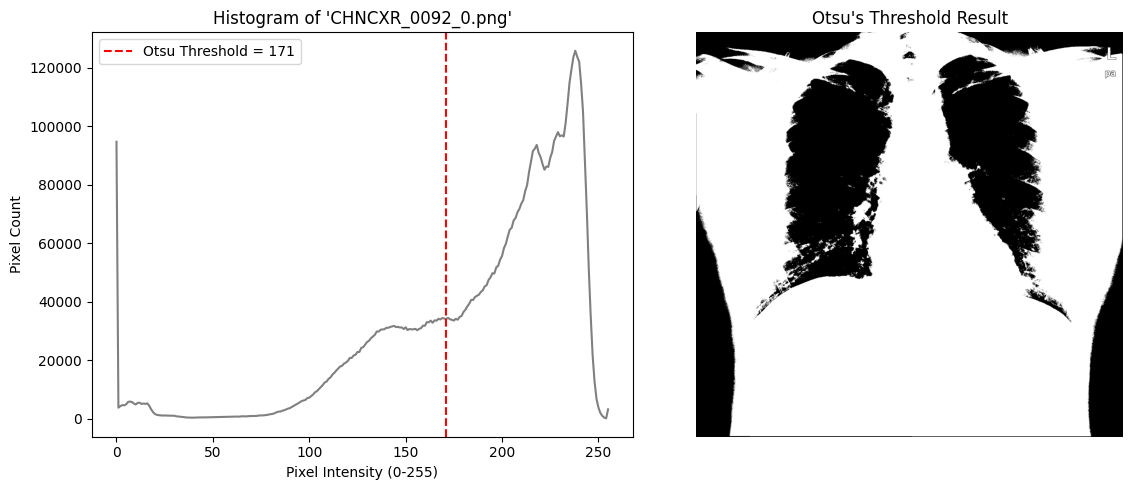

In [9]:
show_histogram_sample("/kaggle/input/pc3-data/PC3_data_split/test/images")